loading data from kaggle to colab

In [5]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [8]:
 !mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [9]:
! cp kaggle.json ~/.kaggle/

In [ ]:
 ! kaggle competitions download -c ngwl-predict-customer-churn --force

imports

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
import pandas as pd
import numpy as np
import itertools
import gc
from datetime import datetime, timedelta, date

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [14]:
addresses = pd.read_csv('addresses.csv.zip')
addresses.shape

(2766724, 2)

In [15]:
ship1 = pd.read_csv('shipments2020-01-01.csv.zip')
ship2 = pd.read_csv('shipments2020-03-01.csv.zip')
ship3 = pd.read_csv('shipments2020-04-30.csv.zip')
ship4 = pd.read_csv('shipments2020-06-29.csv.zip')
ship1.shape, ship2.shape, ship3.shape, ship4.shape

((141546, 20), (400963, 20), (845419, 20), (872758, 20))

In [16]:
#concatenate all shipments
all_shipments = pd.concat([ship1, ship2, ship3, ship4])
del ship1, ship2, ship3, ship4
gc.collect()

77

In [17]:
all_shipments.shape

(2260686, 20)

In [18]:
#get phone_id from addresses
all_shipments = all_shipments.merge(addresses, left_on='ship_address_id', right_on='id', how='left').drop(['id'], axis=1).drop_duplicates()
all_shipments.shape

(2260686, 21)

In [19]:
#get calendar month from order completion timestamp
all_shipments['month'] = pd.to_datetime(all_shipments.order_completed_at).dt.month

### График бесплатной доставки

In [23]:
all_shipments['zero_cost'] = all_shipments.total_cost.apply(lambda x: int(x==0))

In [25]:
all_shipments.zero_cost.value_counts()

0    1766668
1     494018
Name: zero_cost, dtype: int64

In [28]:
all_shipments.groupby('month').zero_cost.size()

month
1      60426
2      81252
3     155755
4     258195
5     441274
6     414987
7     419985
8     428807
12         5
Name: zero_cost, dtype: int64

In [30]:
cost = all_shipments.pivot_table(index=['month'], columns='zero_cost', aggfunc='size', fill_value=0)
cost.columns = ['cost', 'no_cost']

In [31]:
cost

,cost,no_cost
month,,
1,48519,11907
2,68781,12471
3,128527,27228
4,242392,15803
5,378108,63166
6,309125,105862
7,315289,104696
8,275925,152882
12,2,3


In [34]:
cost.drop([12], inplace=True)

Text(0, 0.5, 'процент заказов')

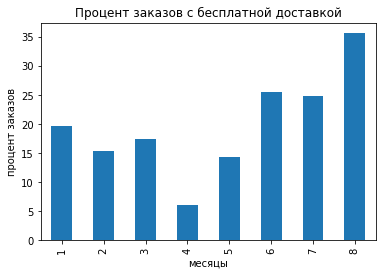

In [150]:
cost_norm = cost.div(cost.sum(axis=1), axis=0).fillna(0)*100
ax = cost_norm.no_cost.plot(kind='bar', title='Процент заказов с бесплатной доставкой')
ax.set_xlabel("месяцы")
ax.set_ylabel("процент заказов")

### График: пользователи/кол-во магазинов по месяцам

In [117]:
retailer_month = all_shipments.groupby(['phone_id', 'month']).retailer.nunique().reset_index()

In [133]:
grouped_retail = retailer_month.groupby(['month', 'retailer']).phone_id.count().unstack().fillna(0).drop([12])

In [134]:
grouped_retail = grouped_retail.div(grouped_retail.sum(axis=1), axis=0).fillna(0)

In [137]:
grouped_retail

retailer,1,2,3,4,5,6,7,11,14,23
month,,,,,,,,,,
1,0.962346,0.037282,0.000266,0.000080,0.000027,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.941878,0.057625,0.000414,0.000062,0.000021,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.894943,0.103784,0.001185,0.000078,0.000011,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.870708,0.125601,0.003502,0.000174,0.000007,0.000000,0.000000,0.000007,0.000000,0.000000
5,0.836140,0.146370,0.017047,0.000437,0.000000,0.000000,0.000000,0.000005,0.000000,0.000000
6,0.830871,0.147482,0.021134,0.000503,0.000005,0.000000,0.000005,0.000000,0.000000,0.000000
7,0.829928,0.147047,0.022287,0.000709,0.000019,0.000005,0.000000,0.000000,0.000005,0.000000
8,0.840798,0.136560,0.021434,0.001131,0.000055,0.000014,0.000005,0.000000,0.000000,0.000005


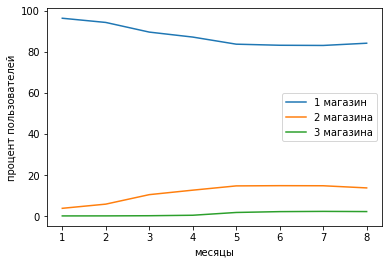

In [146]:
ax = (grouped_retail[[1, 2, 3]]*100).plot(figsize=(6, 4))
ax.set_xlabel("месяцы")
ax.set_ylabel("процент пользователей")
ax.legend(["1 магазин", "2 магазина", "3 магазина"])